In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings, re, string
 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from wordcloud import WordCloud 
from IPython.display import display, Markdown

from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix, precision_score, r2_score, recall_score
from sklearn.pipeline import make_pipeline 
from sklearn.svm import SVC

warnings.filterwarnings('ignore'
                        , category = ConvergenceWarning
                        , module = 'sklearn')

In [2]:
def matriz(y, pred, Modelo = ''):
    mc = confusion_matrix(y, pred)
    Total = sum(np.transpose(mc))
    mcr = np.transpose(np.round(np.transpose(mc) / Total * 100,2))
    MC = pd.DataFrame(mc, columns=['No', 'Si'])

    MC['index'] = ['No', 'Si']
    MC['No'] *= -1

    Grafico = MC.set_index('index').sort_values(['index']
                                                , ascending=False).plot(kind = 'barh'
                                                                        , stacked = True
                                                                        , width = 0.75
                                                                        , color=[['#c9c9c9','#e60000'],['#00c800','#c9c9c9']]
                                                                        , legend = False
                                                                        , figsize = (3,1.2))
    
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
    plt.gca().grid(axis='x',alpha=0)
    plt.gca().grid(axis='y',alpha=0)
    plt.gca().set_xlabel('{:.2f} % - '.format(np.mean(y == pred) * 100) + Modelo
                         , fontsize = 12
                         , alpha = 0.6)
    plt.gca().set_ylabel('')
    
    [spine.set_visible(False) for spine in plt.gca().spines.values()]
    
    plt.show()

In [3]:
def markdown(txt):
    display(Markdown(txt))

In [4]:
df = (pd.read_csv('train-2.csv'
                  , sep = ','
                  , header = 0)
      .sample(frac = 1, random_state = 0))
df.head()

,id,keyword,location,text,target
311,454,armageddon,Wrigley Field,@KatieKatCubs you already know how this shit g...,0
4970,7086,meltdown,Two Up Two Down,@LeMaireLee @danharmon People Near Meltdown Co...,0
527,762,avalanche,Score Team Goals Buying @,1-6 TIX Calgary Flames vs COL Avalanche Presea...,0
6362,9094,suicide%20bomb,Roadside,If you ever think you running out of choices i...,0
800,1160,blight,Laventillemoorings,If you dotish to blight your car go right ahea...,0


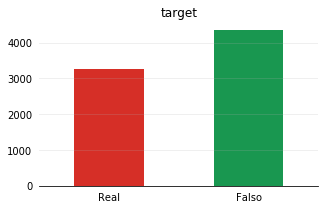

In [5]:
color = plt.get_cmap('RdYlGn')(np.linspace(start = 0.1, stop = 0.9, num = 2))

def plot(df, col, Var = 'id'):
    df_temp = df.groupby([col], as_index = True).count()[Var].sort_values(ascending = True)
    plt.figure(figsize =(5, 3)) 
    Grafico = df_temp.plot(kind = 'bar'
                       , width = 0.5
                       , color = color
                       , stacked = True
                       , legend = False
                       , fontsize = 10)
    Grafico.set_ylabel('')
    Grafico.set_xlabel('')
    
    Grafico.grid(axis='y',alpha=0.25)
    Grafico.set_xticklabels(['Real','Falso'])
    [spine.set_visible(False) for spine in Grafico.spines.values()]
    Grafico.spines['bottom'].set_visible(True)
    
    plt.tick_params(left = False, bottom = False)
    plt.xticks(rotation = 0)
    plt.title(col)
    plt.show()
    plt.close()
    df_temp = None
    
plot(df,'target')

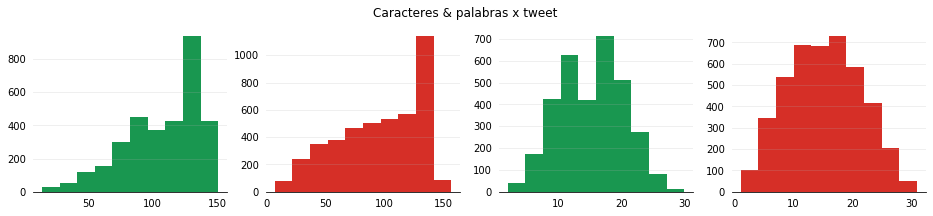

In [6]:
def plotHist(ax, df, filtro):
    Grafico(df[df['target']== filtro].text.str.len(),ax, filtro)
    
def plotWords(ax, df, filtro):
    Grafico(df[df['target']== filtro].text.str.split().map(lambda x: len(x)),ax, filtro)
    
def Grafico(serie, ax, filtro):
    ax.hist(serie, color = color[filtro])
    [spine.set_visible(False) for spine in ax.spines.values()]
    ax.tick_params(left = False, bottom = False)
    ax.spines['bottom'].set_visible(True)
    ax.grid(axis='y',alpha=0.25)
    
fig, ax = plt.subplots(1, 4, figsize = (16,3))

for i in range(2):
    plotHist(ax[i], df, (i + 1) % 2)
    
for i in range(2, 4):
    plotWords(ax[i], df, (i + 1) % 2)

fig.suptitle('Caracteres & palabras x tweet')
plt.show()

In [7]:
def clean_df(df):
    df.text = df.text.apply(lambda x: x.translate(str.maketrans('','', string.punctuation + '¿¡►■')))
    df.text = df.text.apply(lambda x: x.translate(str.maketrans('áéíóúüñÁÉÍÓÚÜÑ','aeiouunAEIOUUN')))
    df.text = df.text.apply(lambda x: re.compile(r'<.*?>').sub(r'',x))
    df.text = df.text.apply(lambda x: re.compile(r'https?://\S+|www\.\S+').sub(r'',x))
    
    return df

df = clean_df(df)

df.head()

,id,keyword,location,text,target
311,454,armageddon,Wrigley Field,KatieKatCubs you already know how this shit go...,0
4970,7086,meltdown,Two Up Two Down,LeMaireLee danharmon People Near Meltdown Comi...,0
527,762,avalanche,Score Team Goals Buying @,16 TIX Calgary Flames vs COL Avalanche Preseas...,0
6362,9094,suicide%20bomb,Roadside,If you ever think you running out of choices i...,0
800,1160,blight,Laventillemoorings,If you dotish to blight your car go right ahea...,0


In [8]:
Punct_List = dict((ord(punct), None) for punct in string.punctuation + '¿¡►■')
    
def TxNormalize(text):
    tokens = word_tokenize(str(text).replace('/',' ').lower().translate(Punct_List))
    return [x for x in tokens if x not in stopwords.words('english')]

def Crear_WordCloud(tokens):    
    if len(tokens) > 0:
        df2 = pd.DataFrame(tokens, columns = ['word'])
        text = ' '.join(review for review in df2.word)

        wc = WordCloud(width = 5000
                       , height = 4000
                       , min_font_size = 14).generate(text) 
        
        plt.figure(figsize = [12, 12])
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')

        plt.show()
        plt.close()
        
def crearGrafico(df):
    plt.figure(figsize = (10, 3))
    
    Grafico = df['word'].value_counts(sort = True).nlargest(25).plot(kind = 'bar')
    plt.tick_params(left = False, bottom = False)
    [spine.set_visible(False) for spine in Grafico.spines.values()]
    Grafico.spines['bottom'].set_visible(True)
    Grafico.grid(axis='y',alpha=0.25)
    plt.show()
    plt.close()
        
def tokenize(df, filtro):
    tokens = []

    for i in df[df.target == filtro].text:
        tokens += TxNormalize(i)
        
    return tokens

### target 0

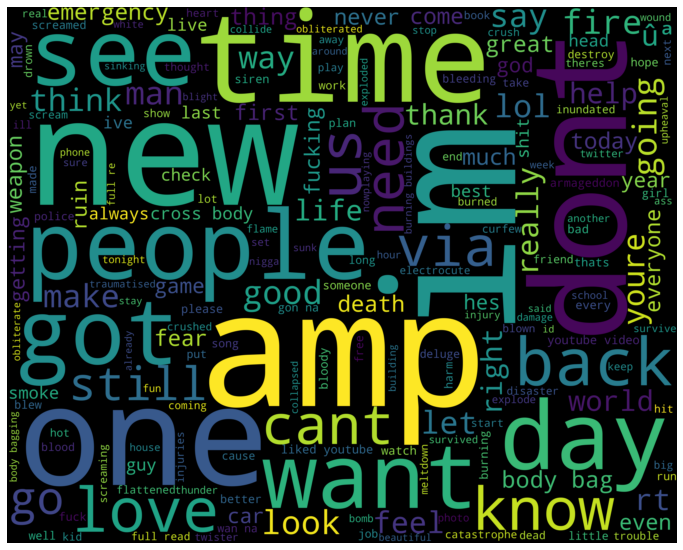

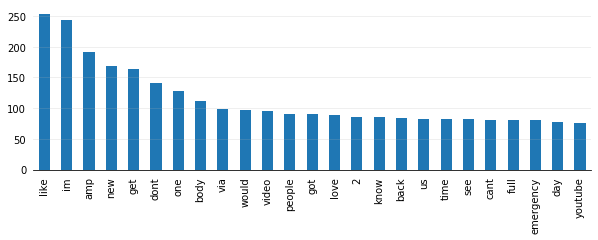

### target 1

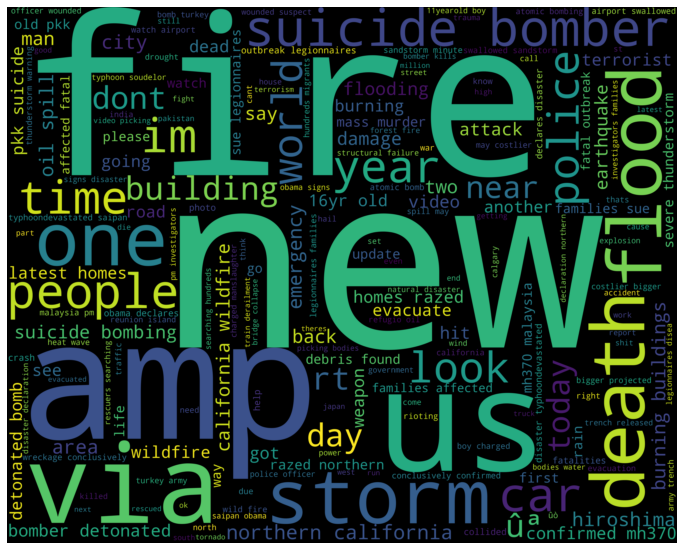

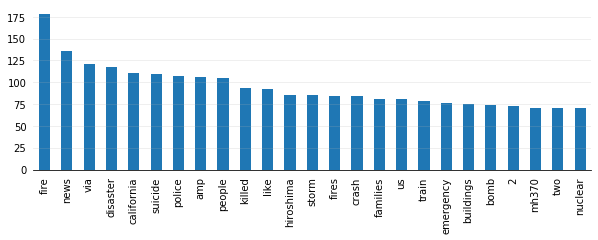

In [9]:
for i in range(2):
    markdown(f'### target ' + str(i))
    tokens = tokenize(df, i)
    Crear_WordCloud(tokens)
    crearGrafico(pd.DataFrame(tokens, columns = ['word']))

In [10]:
Params = {'Regresión Logística': LogisticRegression(C = 1e5
                                                    , class_weight = 'balanced'
                                                    , random_state = 0)
           , 'Pasive Aggressive Classifier': PassiveAggressiveClassifier(max_iter = 50
                                                                         , random_state = 0)
           , 'SGD': SGDClassifier(max_iter = 5
                                  , random_state = 0
                                  , tol = None)
           , 'SVC': SVC(kernel = 'linear'
                        , random_state = 0
                        , gamma = 'scale' )}

XE, XT, ye, yt = train_test_split(df.text
                                  , df.target
                                  , test_size = 0.75
                                  , random_state = 0)

### Comparativa de los distintos modelos:

* Matríz de confusión sobre base text:

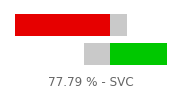

* Precisión modelos sobre base test:

,Modelo,Tipo,Precisión (accuracy),Cross Val,Score (True),R Cuadrado,Recall
0,SVC,SVC,78.53,0.780868,78.06,0.12084,"[0.86, 0.69]"
1,Regresión Logística,LogisticRegression,76.94,0.774536,74.06,0.0555843,"[0.82, 0.7]"
2,Pasive Aggressive Classifier,PassiveAggressiveClassifier,76.78,0.77507,73.49,0.0491304,"[0.81, 0.71]"
3,SGD,SGDClassifier,75.57,0.774544,71.45,-0.000349255,"[0.79, 0.71]"


In [11]:
Result = {}
kf = KFold(n_splits = 10)
           
markdown(f'### Comparativa de los distintos modelos:') 
           
for i in Params:
    Score = []
    clf = make_pipeline(TfidfVectorizer(ngram_range = (1, 2)
                                        , tokenizer = TxNormalize
                                        , stop_words = 'english'
                                        , max_df = 0.7)
                         , Params[i])
    
    clf.fit(XE, ye)
    Score.append(Params[i].__class__.__name__)
    Score.append(round(np.mean(yt == clf.predict(XT)) * 100, 2))
    Score.append(cross_val_score(clf, XE, ye, cv=kf, scoring = 'accuracy').mean())
    Score.append(round(precision_score(yt, clf.predict(XT), labels = [0, 1], pos_label = 1) * 100, 2))
    Score.append(r2_score(yt, clf.predict(XT)))
    Score.append(recall_score(yt, clf.predict(XT), average = None).round(2))
    Result[i] = Score  

Result = (pd.DataFrame(Result, index=['Tipo'
                                      ,'Precisión (accuracy)'
                                      , 'Cross Val' 
                                      , 'Score (True)'
                                      , 'R Cuadrado'
                                      , 'Recall'])
          .transpose()
          .sort_values(by = 'Precisión (accuracy)'
                       , ascending = False)
          .reset_index()
          .rename(columns = {'index':'Modelo'}))

markdown(f'* Matríz de confusión sobre base text:')

Best = make_pipeline(TfidfVectorizer(stop_words = 'english', max_df = 0.7)
                         , Params[Result['Modelo'][0]])

Best.fit(XE, ye)

Grafico = matriz(yt, Best.predict(XT), Result['Modelo'][0])        
markdown(f'* Precisión modelos sobre base test:')

Result

In [12]:
df = (pd.read_csv('test-2.csv'
                  , sep = ','
                  , header = 0))

df = clean_df(df)
df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,Heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [13]:
df['target'] = Best.predict(df.text)

In [14]:
df[['id','target']].to_csv('submission.csv', index = False)